In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import matplotlib.colors as mcolors
import os

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.26.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [3]:
outdir = '/Users/cdpolt/Documents/Xenium_Pilot'

In [4]:
file_paths = [
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_1/cell_feature_matrix.h5',
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_2/cell_feature_matrix.h5',
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_3/cell_feature_matrix.h5',
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_4/cell_feature_matrix.h5',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_5/cell_feature_matrix.h5',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_6/cell_feature_matrix.h5',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_7/cell_feature_matrix.h5',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_8/cell_feature_matrix.h5'
]


In [5]:
adatas = [sc.read_10x_h5(file) for file in file_paths]

reading /Users/cdpolt/Documents/Xenium_Pilot/Sample_1/cell_feature_matrix.h5
 (0:00:00)
reading /Users/cdpolt/Documents/Xenium_Pilot/Sample_2/cell_feature_matrix.h5
 (0:00:00)
reading /Users/cdpolt/Documents/Xenium_Pilot/Sample_3/cell_feature_matrix.h5
 (0:00:00)
reading /Users/cdpolt/Documents/Xenium_Pilot/Sample_4/cell_feature_matrix.h5
 (0:00:00)
reading /Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_5/cell_feature_matrix.h5
 (0:00:00)
reading /Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_6/cell_feature_matrix.h5
 (0:00:00)
reading /Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_7/cell_feature_matrix.h5
 (0:00:00)
reading /Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_8/cell_feature_matrix.h5
 (0:00:00)


In [6]:
spatial_paths = [
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_1/cells.csv',
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_2/cells.csv',
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_3/cells.csv.gz',
    '/Users/cdpolt/Documents/Xenium_Pilot/Sample_4/cells.csv.gz',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_5/cells.csv',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_6/cells.csv',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_7/cells.csv',
    '/Users/cdpolt/Documents/Xenium_Pilot/Xenium_2/Sample_8/cells.csv'
]

In [7]:
# Read in the spatial files and update the AnnData objects
for i, spatial_csv in enumerate(spatial_paths):
    # Load the spatial data
    df_spatial = pd.read_csv(spatial_csv)
    df_spatial.set_index(adatas[i].obs_names, inplace=True)
    adatas[i].obs = df_spatial.copy()
    
    # Update the spatial coordinates
    adatas[i].obsm['spatial'] = adatas[i].obs[['x_centroid', 'y_centroid']].copy().to_numpy()

# Concatenate all the AnnData objects
adata = adatas[0].concatenate(*adatas[1:])

/var/folders/lv/4kzbmh794nj2w9tkbzhljhgh0000gn/T/ipykernel_31260/1436028905.py:12: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(*adatas[1:])


In [8]:
sc.pp.filter_cells(adata, min_counts = 20)
adata

filtered out 243835 cells that have less than 20 counts


AnnData object with n_obs × n_vars = 694624 × 280
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'batch', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [9]:
adata.layers['counts'] = adata.X.copy()

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [11]:
sc.pp.scale(adata, max_value = 10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [12]:
sc.pp.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:49)


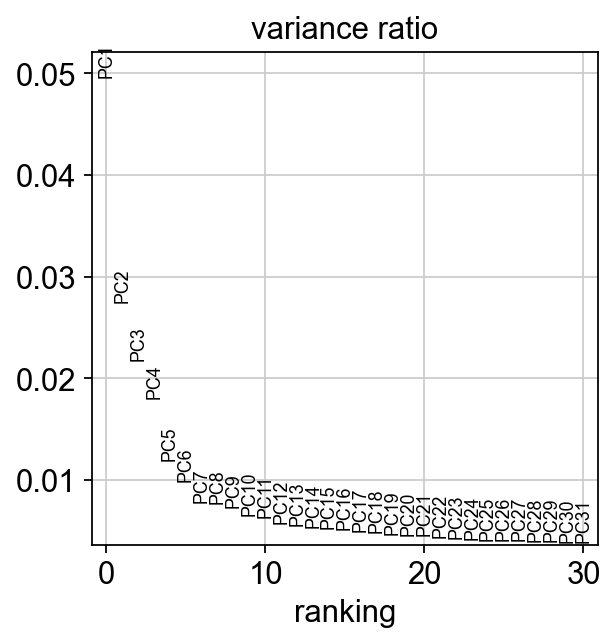

In [13]:
sc.pl.pca_variance_ratio(adata)

In [14]:
sc.external.pp.harmony_integrate(adata, 'batch', basis = 'X_pca', adjusted_basis = 'X_pca_harmony')

2024-07-31 19:06:58,461 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-07-31 19:08:16,881 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-31 19:08:18,488 - harmonypy - INFO - Iteration 1 of 10
2024-07-31 19:11:15,736 - harmonypy - INFO - Iteration 2 of 10
2024-07-31 19:14:03,158 - harmonypy - INFO - Converged after 2 iterations


In [15]:
sc.pp.neighbors(adata, n_neighbors = 100, n_pcs = 30, use_rep = 'X_pca_harmony')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:23)


In [16]:
sc.tl.umap(adata, random_state = 1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:12:24)


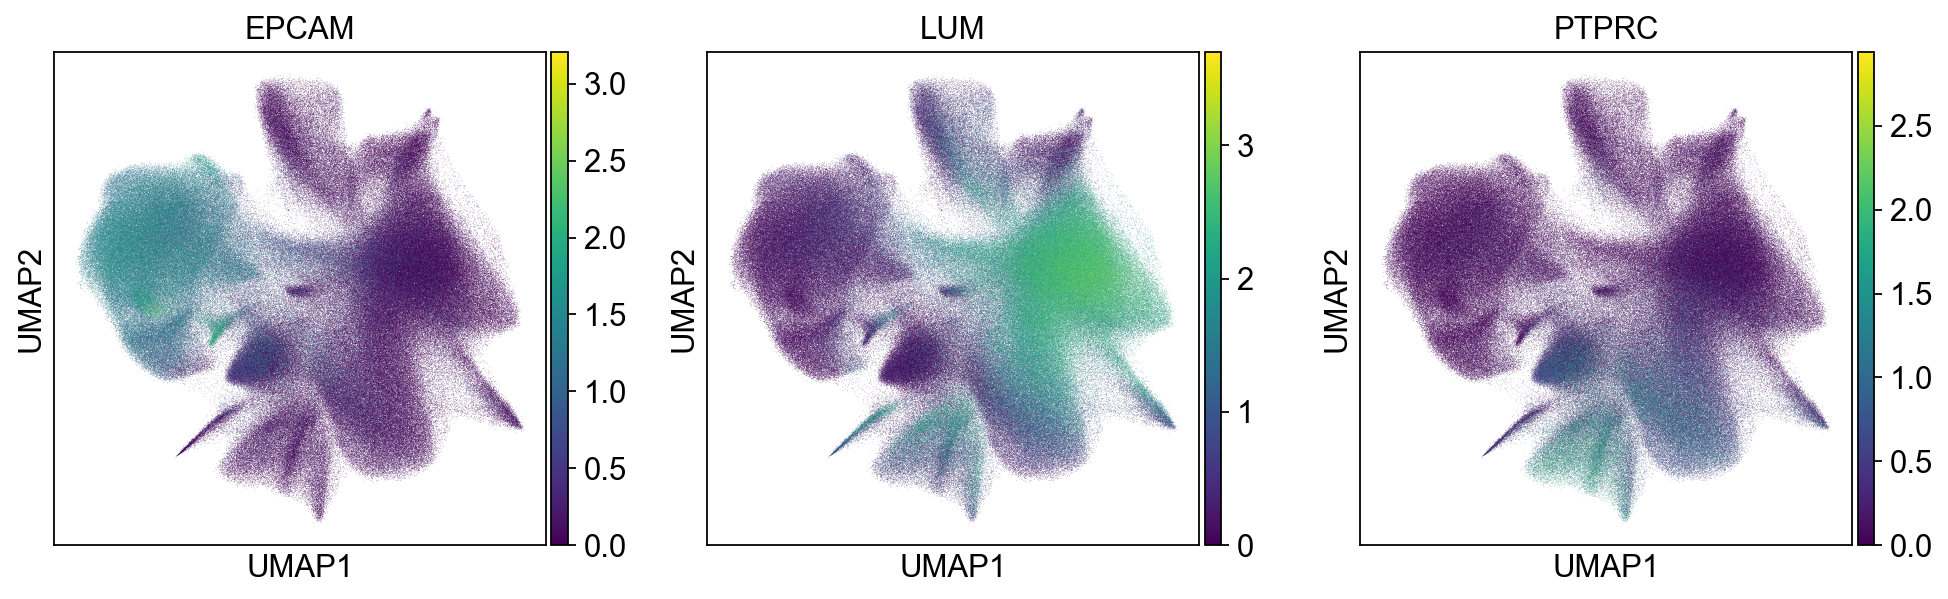

In [17]:
sc.pl.umap(adata, color = ['EPCAM', 'LUM', 'PTPRC'])

In [18]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (15:56:16)


/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


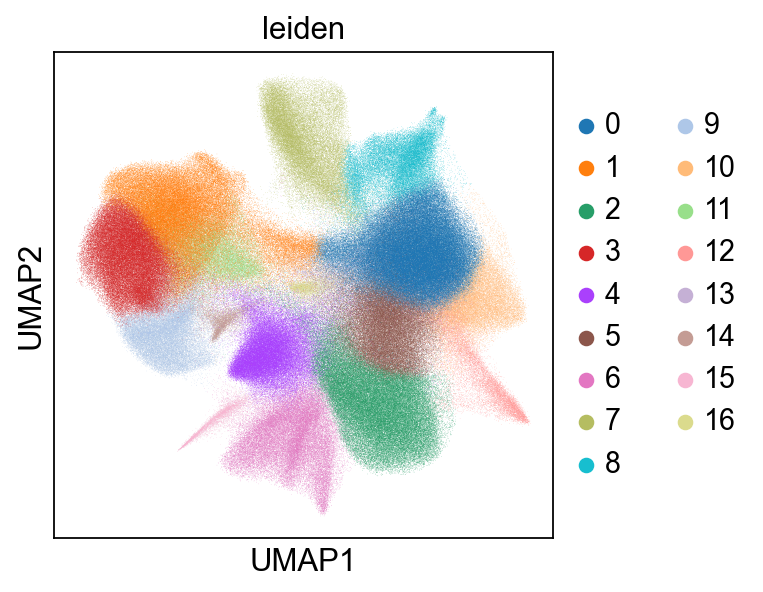

In [19]:
sc.pl.umap(adata, color = 'leiden')

In [20]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


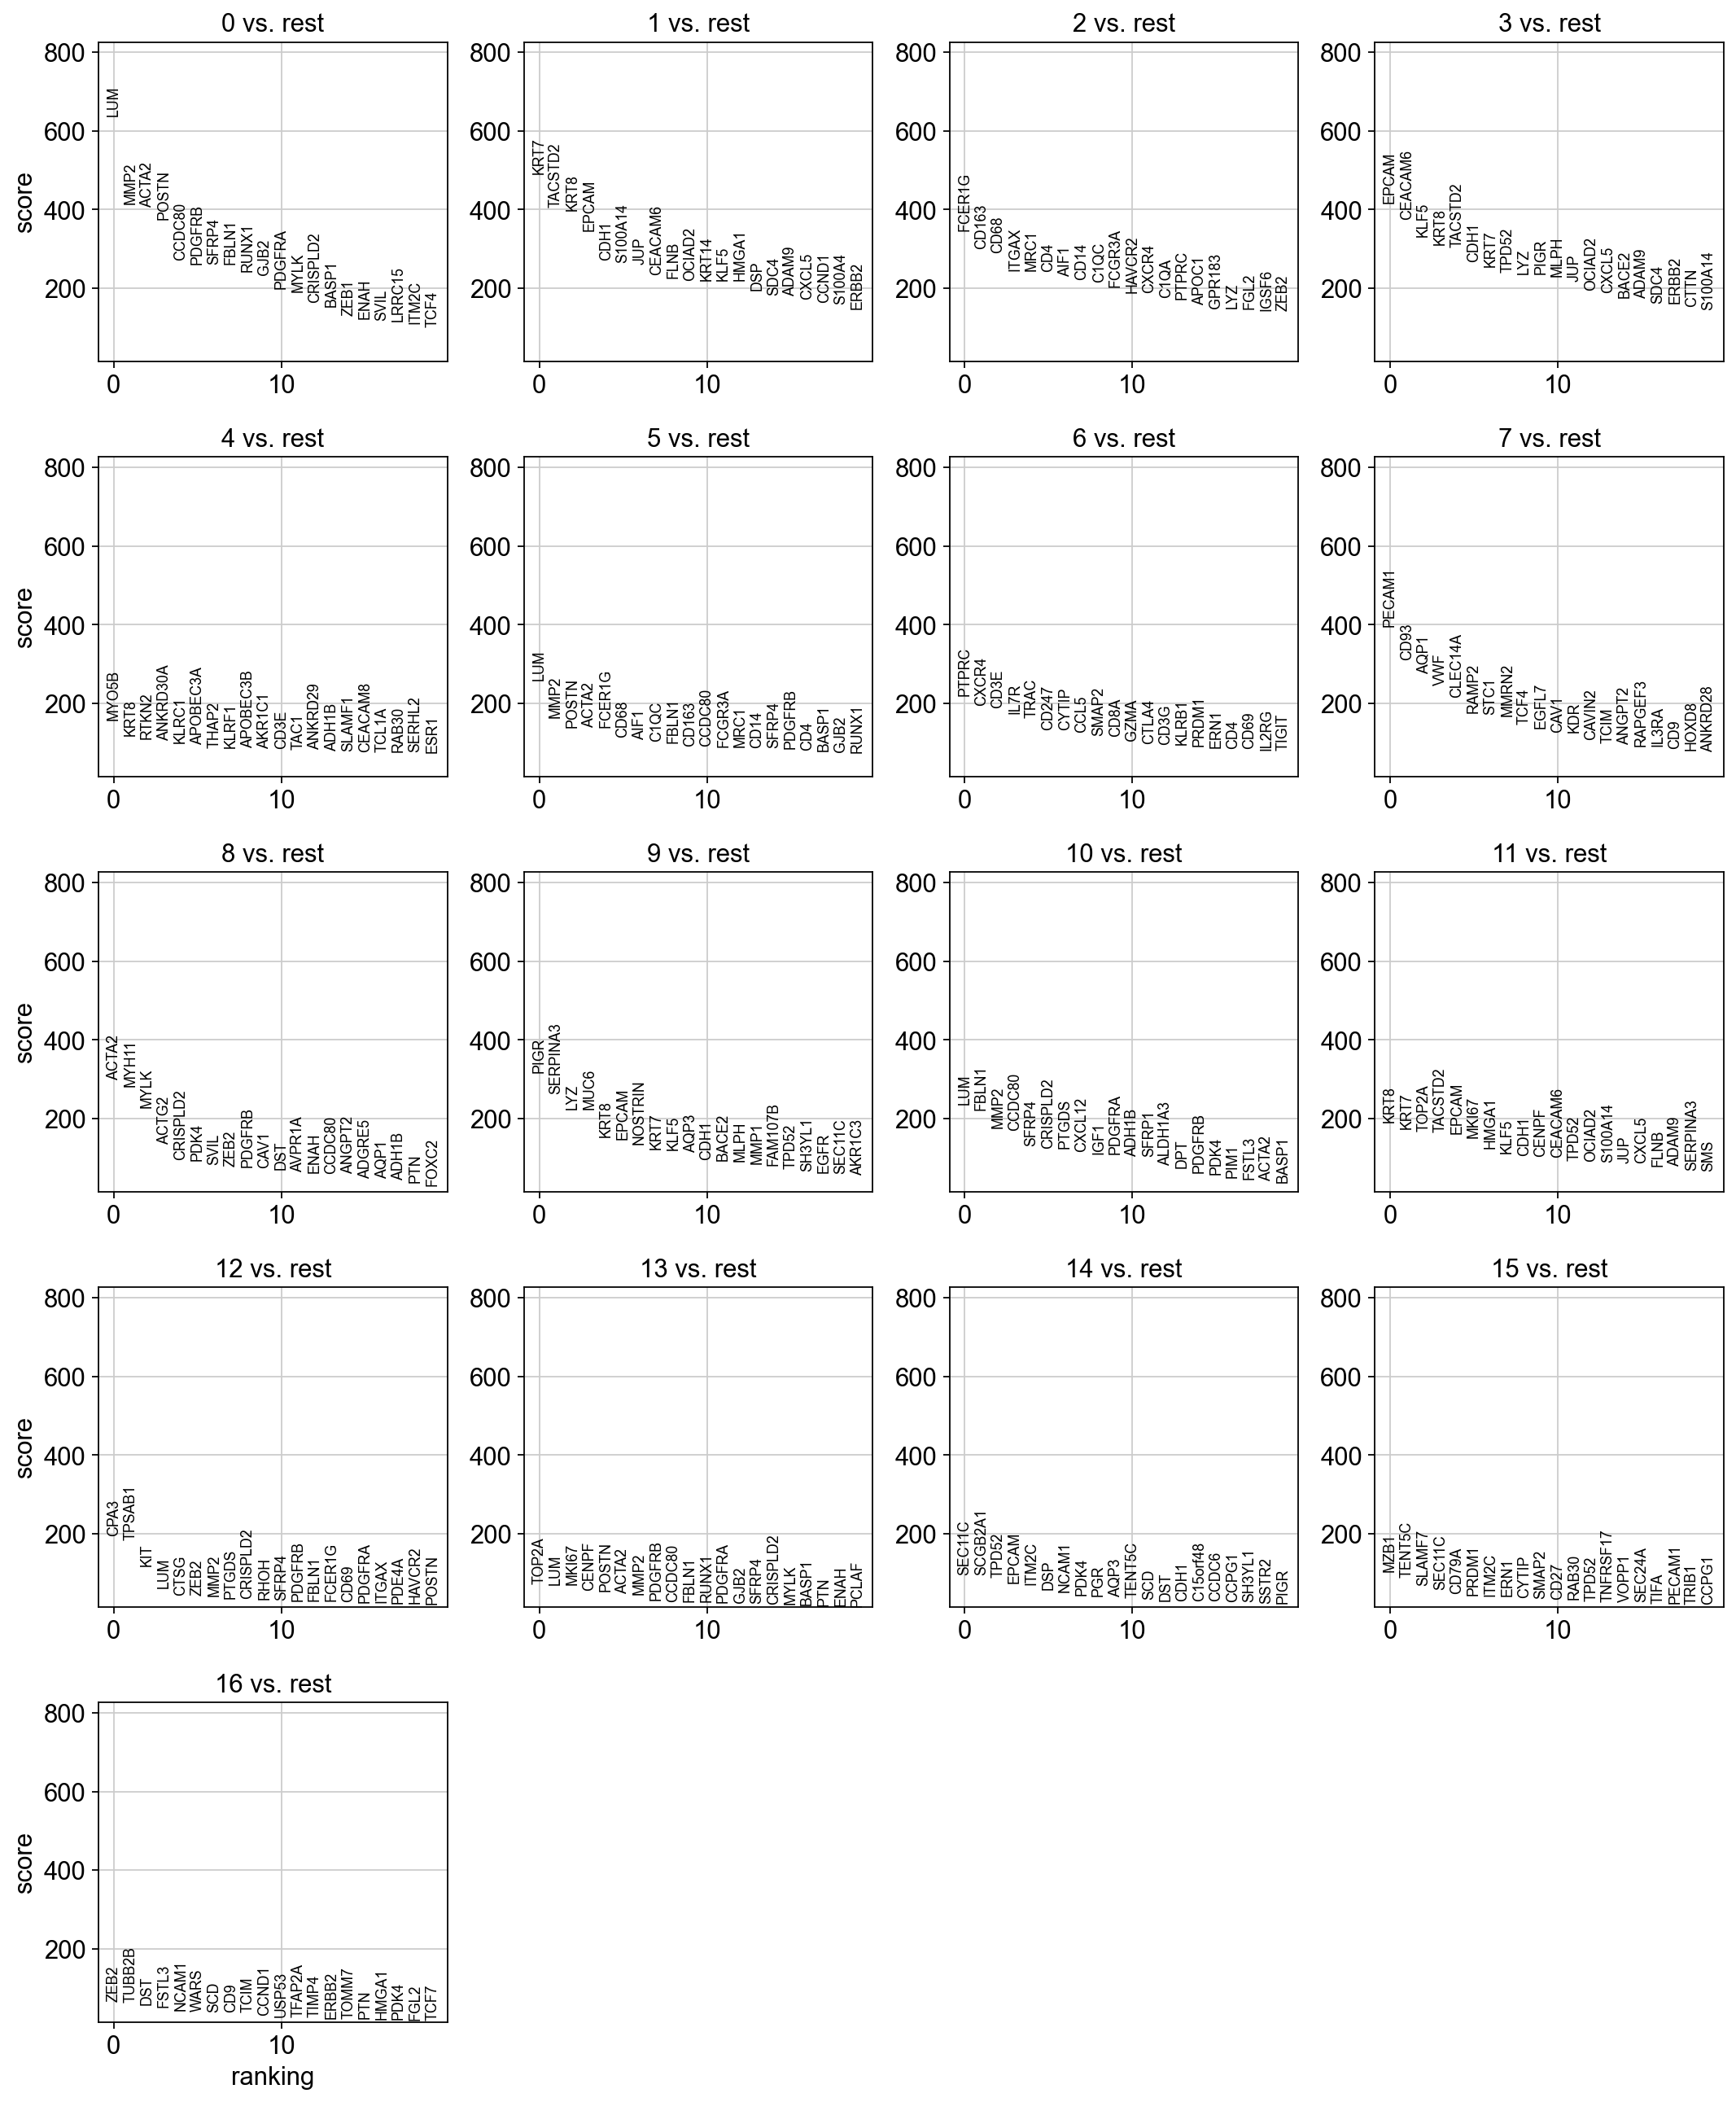

In [21]:
sc.pl.rank_genes_groups(adata)

In [56]:
cell_type_mapping = {
    '0': 'myCAF', 
    '1': 'Malignant 1 (Bas)', 
    '2': 'Macrophage 1',
    '3': 'Malignant 2 (Cls)', 
    '4': 'Neutrophil', 
    '5': 'Macrophage 2', 
    '6': 'T cell', 
    '7': 'Endothelial',
    '8': 'Smooth muscle',
    '9': 'Epithelial (ADM-like)',
    '10': 'iCAF',
    '11': 'Proliferative malignant',
    '12': 'Mast cell', 
    '13': 'Proliferative fibroblast',
    '14': 'Malignant 3 (SCGB2A1+)',
    '15': 'B, Plasma cell',
    '16': 'Other'
}

adata.obs['Cell Type'] = adata.obs['leiden'].map(cell_type_mapping)


In [84]:
def generate_cmap_dict(labels, colormap):
    unique_labels = sorted(labels.unique())
    cmap = plt.get_cmap(colormap, len(unique_labels))
    colors = [cmap(i) for i in range(cmap.N)]
    hex_colors = [mcolors.rgb2hex(color) for color in colors]
    color_dict = dict(zip(unique_labels, hex_colors))
    return color_dict
    
# Assuming `adata` is your AnnData object
cell_types = adata.obs['Cell Type']

# Generate colormap dictionary for Cell Types
CT_cmap = generate_cmap_dict(cell_types, 'tab20b')

# Store the colormap dictionary in adata.uns
adata.uns['CT_cmap'] = CT_cmap

/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


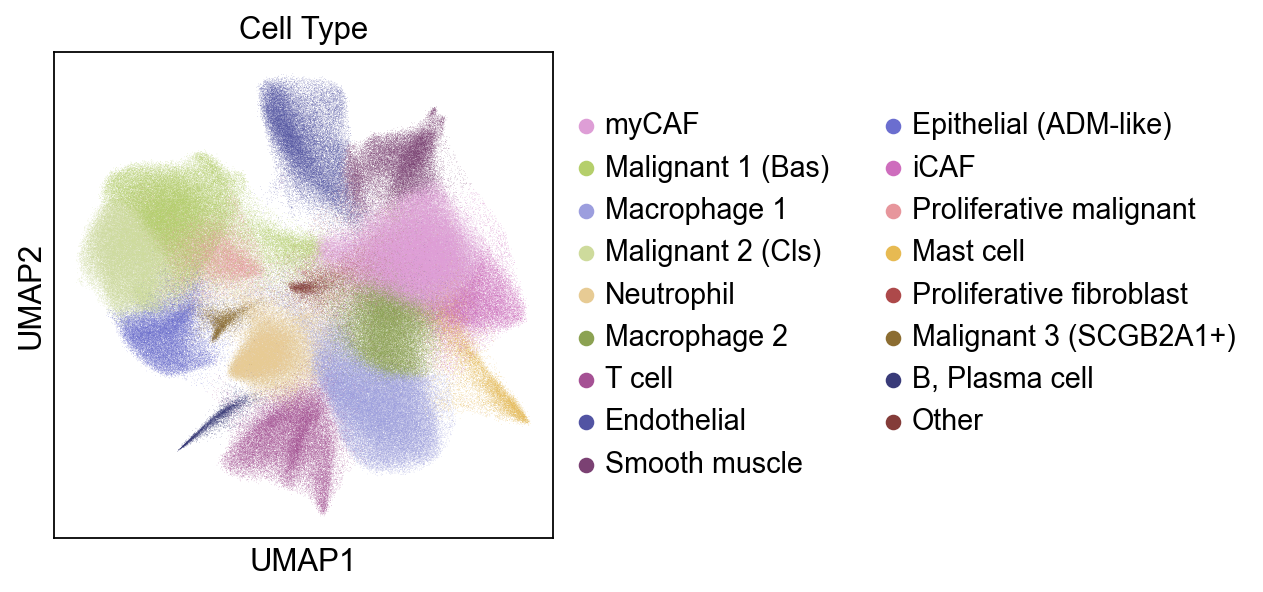

In [86]:
sc.pl.umap(adata, color = 'Cell Type', palette = adata.uns['CT_cmap'], save = 'Cell Types')

categories: myCAF, Malignant 1 (Bas), Macrophage 1, etc.
var_group_labels: 0, 1, 2, etc.


/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/cdpolt/anaconda3/envs/squidpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

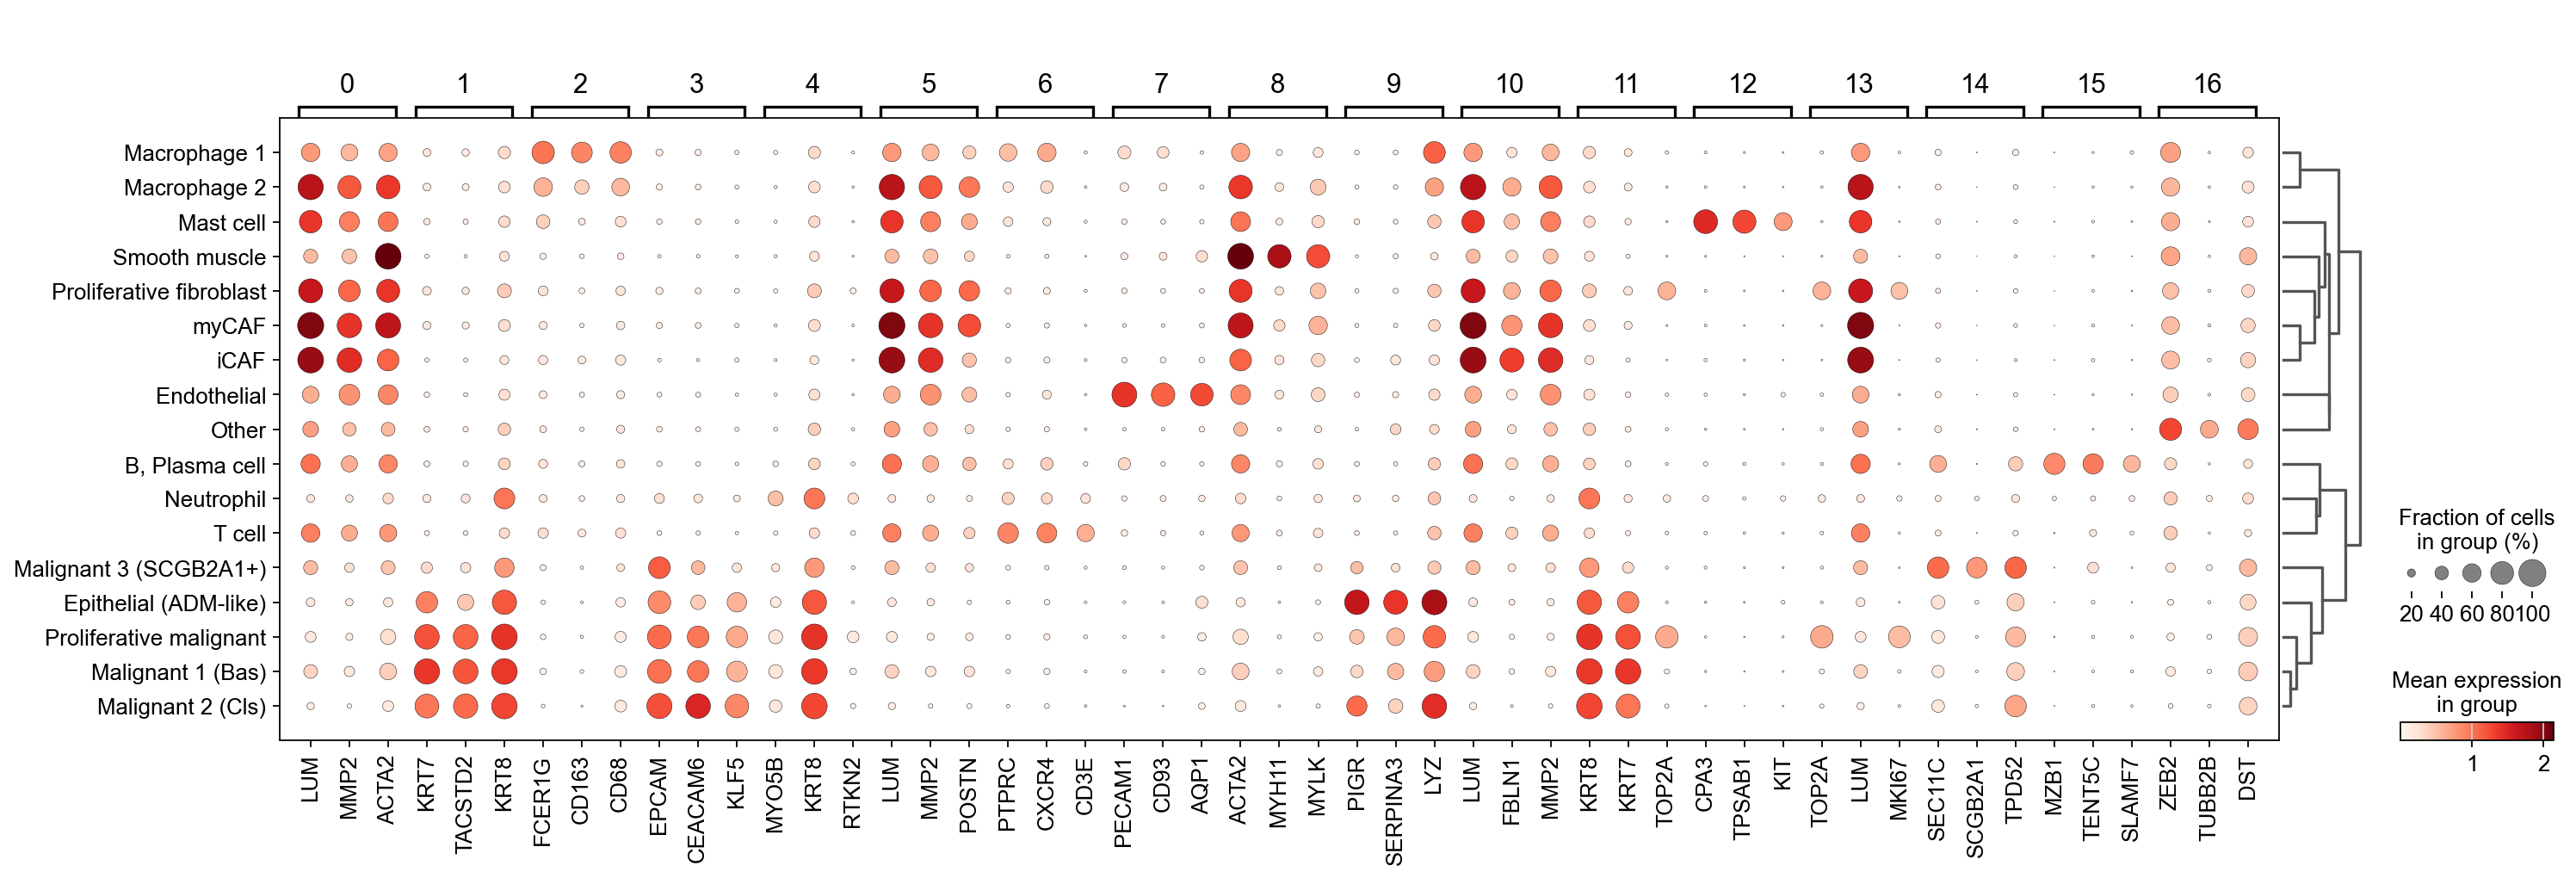

In [70]:
sc.pl.rank_genes_groups_dotplot(adata, groupby = 'Cell Type', n_genes = 3, save = 'marker_genes.png')

In [24]:
fname = 'Xenium Cell Typing.h5ad'
full_path = os.path.join(outdir, fname)

In [88]:
adata.write(full_path)